In [2]:
#importing libraries
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
 
from sklearn.calibration import calibration_curve
from sklearn import preprocessing
 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
 
#importing Basic Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from lightgbm import LGBMClassifier
 
from xgboost import XGBClassifier

In [3]:

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

Definition of all the functions for classifier model evaluation

In [4]:
from sklearn.metrics import confusion_matrix
#function for making a confusion matrix & visualize that
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Hypertension','No Hypertension']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
print('plot_cm defined')   

# Define function to calculate average precision score & to determine precision & recall vector to plot a PR graph.
from sklearn.metrics import average_precision_score, precision_recall_curve

def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()
    
target_names = ['Hypertension ', 'No Hypertension']
print('plot_aucprc defined') 

def calc_prevalence(y1):
    return (sum(y1)/len(y1))   

thresh = 0.5
print('calc_prevalence defined') 

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

print('calc_specificity defined') 

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    sensitivity = 1/specificity
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('sensitivity:%.3f'%sensitivity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))

    print(' ')
    return auc, accuracy, recall, precision, specificity


np.random.seed(1234)
rng=np.random.RandomState(1234)

print('print_report defined') 

def get_ci_auc( ytest, y_valid_preds ): 

    from scipy.stats import sem
    from sklearn.metrics import roc_auc_score 
   
    n_bootstraps = 1000   
    bootstrapped_scores = []   
   
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_valid_preds) - 1, len(y_valid_preds))
        #print('indices',np.unique(ytest[indices]))
        #print(indices)
        if len(np.unique(ytest[indices])) <= 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            score = roc_auc_score(ytest[indices], y_valid_preds[indices])
            bootstrapped_scores.append(score) 

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

   # 90% c.i.    
    confidence_lower = int(0.025 * len(sorted_scores))
    confidence_upper = int(0.975 * len(sorted_scores))

    return confidence_lower,confidence_upper

print('get_ci_auc defined')

plot_cm defined
plot_aucprc defined
calc_prevalence defined
calc_specificity defined
print_report defined
get_ci_auc defined


In [5]:
#os.chdir(r"/content/drive/MyDrive/Research for predicting hypertension/Dataset")
#dataset = pd.read_csv("Hypertension_data.csv")
#dataset = pd.read_csv("Hypertention.csv",sep=';')
dataset = pd.read_csv("MGE303_Term Project_Classification_Data (Disease).csv")

In [6]:
dataset.columns

Index(['HY_YN', 'AGE', 'gender', 'WAIST', 'BP_HIGH', 'BP_LWST', 'BLDS',
       'TOT_CHOLE', 'SGOT_ASL', 'SGPT_ALT', 'GAMMA_GTP', 'HMG', 'H_APOP_YN',
       'H_HDISE_YN', 'H_DIABML_YN', 'F_APOP_YN', 'F_HDISE_YN', 'F_HPRT_YN',
       'F_DIABML_YN', 'DSQTY', 'SMK_TERM', 'EXER_M'],
      dtype='object')

In [7]:
dataset.shape

(21613, 22)

In [8]:
dataset.head()

,HY_YN,AGE,gender,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,SGOT_ASL,SGPT_ALT,...,H_APOP_YN,H_HDISE_YN,H_DIABML_YN,F_APOP_YN,F_HDISE_YN,F_HPRT_YN,F_DIABML_YN,DSQTY,SMK_TERM,EXER_M
0,1,66,1,76.0,120.0,70.0,87.0,199.0,22.0,13.0,...,0,0,0,0,0,0,0,0,5,Once a week
1,1,55,1,84.0,110.0,80.0,85.0,178.0,40.0,35.0,...,0,0,0,0,0,0,0,0,0,Never
2,1,54,0,84.0,117.0,76.0,92.0,195.0,20.0,20.0,...,0,0,0,0,0,0,0,0,0,Once a week
3,1,29,1,80.0,126.0,82.0,86.0,150.0,25.0,27.0,...,0,0,0,0,0,0,0,1,3,Once a week
4,1,43,1,82.0,130.0,85.0,104.0,134.0,31.0,23.0,...,0,0,0,0,0,0,0,2,3,Once a week


In [9]:
dataset.isnull().sum()

HY_YN           0
AGE             0
gender          0
WAIST          44
BP_HIGH         3
BP_LWST         3
BLDS            1
TOT_CHOLE       0
SGOT_ASL       27
SGPT_ALT       22
GAMMA_GTP      81
HMG             6
H_APOP_YN       0
H_HDISE_YN      0
H_DIABML_YN     0
F_APOP_YN       0
F_HDISE_YN      0
F_HPRT_YN       0
F_DIABML_YN     0
DSQTY           0
SMK_TERM        0
EXER_M          0
dtype: int64

In [10]:
dataset = dataset.dropna()

In [11]:
dataset.isnull().sum()

HY_YN          0
AGE            0
gender         0
WAIST          0
BP_HIGH        0
BP_LWST        0
BLDS           0
TOT_CHOLE      0
SGOT_ASL       0
SGPT_ALT       0
GAMMA_GTP      0
HMG            0
H_APOP_YN      0
H_HDISE_YN     0
H_DIABML_YN    0
F_APOP_YN      0
F_HDISE_YN     0
F_HPRT_YN      0
F_DIABML_YN    0
DSQTY          0
SMK_TERM       0
EXER_M         0
dtype: int64

In [12]:
dataset.shape

(21450, 22)

In [13]:
from collections import Counter
print("The number of values for column: HY_YN {}".format(Counter(dataset.HY_YN)))
print("The number of values for column: AGE {}".format(Counter(dataset.AGE)))
print("The number of values for column: gender {}".format(Counter(dataset.gender)))
print("The number of values for column: WAIST {}".format(Counter(dataset.WAIST)))
print("The number of values for column: BP_HIGH {}".format(Counter(dataset.BP_HIGH)))
print("The number of values for column: BP_LWST {}".format(Counter(dataset.BP_LWST)))
print("The number of values for column: BLDS {}".format(Counter(dataset.BLDS)))
print("The number of values for column: TOT_CHOLE {}".format(Counter(dataset.TOT_CHOLE)))
print("The number of values for column: SGOT_ASL {}".format(Counter(dataset.SGOT_ASL)))
print("The number of values for column: SGPT_ALT {}".format(Counter(dataset.SGPT_ALT)))
print("The number of values for column: GAMMA_GTP {}".format(Counter(dataset.GAMMA_GTP)))
print("The number of values for column: HMG {}".format(Counter(dataset.HMG)))
print("The number of values for column: H_APOP_YN {}".format(Counter(dataset.H_APOP_YN)))
print("The number of values for column: H_HDISE_YN {}".format(Counter(dataset.H_HDISE_YN)))
print("The number of values for column: H_DIABML_YN {}".format(Counter(dataset.H_DIABML_YN)))
print("The number of values for column: F_APOP_YN {}".format(Counter(dataset.F_APOP_YN)))
print("The number of values for column: F_HDISE_YN {}".format(Counter(dataset.F_HDISE_YN)))
print("The number of values for column: F_HPRT_YN {}".format(Counter(dataset.F_HPRT_YN)))
print("The number of values for column: F_DIABML_YN {}".format(Counter(dataset.F_DIABML_YN)))
print("The number of values for column: DSQTY {}".format(Counter(dataset.DSQTY)))
print("The number of values for column: SMK_TERM {}".format(Counter(dataset.SMK_TERM)))
print("The number of values for column: EXER_M {}".format(Counter(dataset.EXER_M)))


The number of values for column: HY_YN Counter({0: 16102, 1: 5348})
The number of values for column: AGE Counter({48: 836, 40: 817, 46: 793, 42: 756, 44: 693, 50: 685, 29: 636, 52: 632, 28: 605, 27: 601, 34: 583, 36: 569, 38: 556, 56: 550, 37: 550, 54: 548, 31: 536, 32: 535, 35: 531, 47: 530, 39: 526, 49: 518, 30: 516, 43: 507, 33: 505, 26: 501, 45: 488, 41: 439, 60: 425, 51: 409, 25: 393, 58: 388, 66: 347, 62: 314, 53: 293, 64: 269, 24: 261, 55: 252, 68: 243, 23: 218, 57: 203, 59: 170, 61: 154, 22: 140, 63: 96, 21: 91, 65: 89, 69: 55, 67: 50, 20: 48})
The number of values for column: gender Counter({1: 12449, 0: 9001})
The number of values for column: WAIST Counter({81.0: 1123, 80.0: 1035, 76.0: 974, 82.0: 925, 86.0: 904, 78.0: 861, 84.0: 838, 83.0: 809, 85.0: 799, 79.0: 775, 74.0: 758, 77.0: 753, 75.0: 692, 88.0: 670, 71.0: 661, 70.0: 622, 72.0: 622, 73.0: 613, 87.0: 599, 68.0: 564, 90.0: 547, 69.0: 517, 89.0: 506, 66.0: 422, 91.0: 417, 67.0: 370, 92.0: 352, 65.0: 280, 93.0: 266, 94.

In [14]:
# using the replace() method

dataset.replace(to_replace ="Never", 
                 value = 0, 
                  inplace = True)
dataset.replace(to_replace ="Once a week", 
                 value = 1, 
                  inplace = True)
dataset.replace(to_replace ="2-3 a week", 
                 value = 2, 
                  inplace = True)
dataset.replace(to_replace =">5 a week", 
                 value = 3, 
                  inplace = True)
dataset.replace(to_replace ="4-5 a week", 
                 value = 4, 
                  inplace = True)
# writing  the dataframe to another csv file
#dataset.to_csv('outputfile.csv', 
                 #index = False)

In [15]:
dataset.head()

,HY_YN,AGE,gender,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,SGOT_ASL,SGPT_ALT,...,H_APOP_YN,H_HDISE_YN,H_DIABML_YN,F_APOP_YN,F_HDISE_YN,F_HPRT_YN,F_DIABML_YN,DSQTY,SMK_TERM,EXER_M
0,1,66,1,76.0,120.0,70.0,87.0,199.0,22.0,13.0,...,0,0,0,0,0,0,0,0,5,1
1,1,55,1,84.0,110.0,80.0,85.0,178.0,40.0,35.0,...,0,0,0,0,0,0,0,0,0,0
2,1,54,0,84.0,117.0,76.0,92.0,195.0,20.0,20.0,...,0,0,0,0,0,0,0,0,0,1
3,1,29,1,80.0,126.0,82.0,86.0,150.0,25.0,27.0,...,0,0,0,0,0,0,0,1,3,1
4,1,43,1,82.0,130.0,85.0,104.0,134.0,31.0,23.0,...,0,0,0,0,0,0,0,2,3,1


In [16]:
x1 = dataset.drop(['HY_YN'], axis=1)
y1 = dataset['HY_YN']
print(y1.shape)

(21450,)


In [17]:
#x1 = dataset.drop(['prevalentHyp'], axis=1)
#y1 = dataset['prevalentHyp']

Best Features selection using pearson correlation coeff. formula

In [18]:
X_train = x1
y_train = y1
feature_name = list(X_train.columns)
# no of maximum features we need to select
num_feats =21
#Here pearson correlation coefficient formula have been used in the defined function to find correlation of every field with target field in order to make a list of field only which have correlation with the target feild.
def cor_selector(X_train, y_train,num_feats):
    cor_list = []
    feature_name = X_train.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X_train.columns.tolist():
        cor = np.corrcoef(X_train[i], y_train)[0, 1]
        cor_list.append(cor)    
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    for i in range(len(feature_name)):
        print(feature_name[i]+":"+str(cor_list[i]))
    # feature name
    cor_feature = X_train.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_train, y_train,num_feats)
print(str(len(cor_feature)), 'selected features')

AGE:0.16814007150697227
gender:0.17974887603452058
WAIST:0.2378064483016276
BP_HIGH:0.3140306454066983
BP_LWST:0.29715395238109077
BLDS:0.08396159372985644
TOT_CHOLE:0.11079499351201344
SGOT_ASL:0.11732736742776402
SGPT_ALT:0.12562921808419383
GAMMA_GTP:0.16079333376237182
HMG:0.15223765860829663
H_APOP_YN:0.0039898091788405105
H_HDISE_YN:0.011897215567133846
H_DIABML_YN:0.01178750425339605
F_APOP_YN:0.01677643575936807
F_HDISE_YN:0.010146317116308815
F_HPRT_YN:0.008548252564424935
F_DIABML_YN:-0.005732857895305629
DSQTY:0.06921897659045782
SMK_TERM:0.10001237504227234
EXER_M:0.038529490068535566
21 selected features


In [19]:
cor_feature


['H_APOP_YN',
 'F_DIABML_YN',
 'F_HPRT_YN',
 'F_HDISE_YN',
 'H_DIABML_YN',
 'H_HDISE_YN',
 'F_APOP_YN',
 'EXER_M',
 'DSQTY',
 'BLDS',
 'SMK_TERM',
 'TOT_CHOLE',
 'SGOT_ASL',
 'SGPT_ALT',
 'HMG',
 'GAMMA_GTP',
 'AGE',
 'gender',
 'WAIST',
 'BP_LWST',
 'BP_HIGH']

Best features selection using SelectKbest method

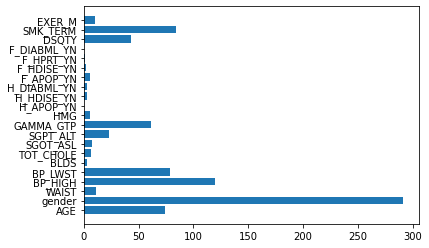

21 selected features


In [20]:
X_norm = MinMaxScaler().fit_transform(X_train)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector = chi_selector.fit(X_norm, y_train)
chi_scores = pd.DataFrame(chi_selector.scores_)[0].to_list()
chi_columns = pd.DataFrame(X_train.columns)[0].to_list()
plt.barh(chi_columns,chi_scores)
plt.show()
chi_support = chi_selector.get_support()
chi_feature = X_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

Best features selection using RFE method

In [21]:
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

21 selected features


Best feature selection using SelectFromModel method

In [22]:
from sklearn.feature_selection import SelectFromModel
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y_train)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
embeded_lr_feature

8 selected features


['AGE',
 'WAIST',
 'BP_HIGH',
 'BP_LWST',
 'TOT_CHOLE',
 'SGOT_ASL',
 'GAMMA_GTP',
 'HMG']

In [23]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X_train, y_train)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
embeded_rf_feature

10 selected features


['AGE',
 'WAIST',
 'BP_HIGH',
 'BP_LWST',
 'BLDS',
 'TOT_CHOLE',
 'SGOT_ASL',
 'SGPT_ALT',
 'GAMMA_GTP',
 'HMG']

Best feature selection using LGBMClassifier method

In [24]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X_train, y_train)
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')
embeded_lgb_feature

8 selected features


['AGE', 'WAIST', 'BP_LWST', 'BLDS', 'TOT_CHOLE', 'SGOT_ASL', 'SGPT_ALT', 'HMG']

In [25]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top feature
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,WAIST,True,True,True,True,True,True,6
2,TOT_CHOLE,True,True,True,True,True,True,6
3,SGOT_ASL,True,True,True,True,True,True,6
4,HMG,True,True,True,True,True,True,6
5,BP_LWST,True,True,True,True,True,True,6
6,AGE,True,True,True,True,True,True,6
7,SGPT_ALT,True,True,True,False,True,True,5
8,GAMMA_GTP,True,True,True,True,True,False,5
9,BP_HIGH,True,True,True,True,True,False,5
10,BLDS,True,True,True,False,True,True,5


In [26]:
#all -> 'AGE', 'gender', 'WAIST', 'BP_HIGH', 'BP_LWST', 'BLDS','TOT_CHOLE', 'SGOT_ASL', 'SGPT_ALT', 'GAMMA_GTP', 'HMG', 'H_APOP_YN', 'H_HDISE_YN', 'H_DIABML_YN', 'F_APOP_YN', 'F_HDISE_YN', 'F_HPRT_YN','F_DIABML_YN', 'DSQTY', 'SMK_TERM', 'EXER_M' 
#8   -> 'AGE', 'WAIST','BP_HIGH','BP_LWST','TOT_CHOLE','SGOT_ASL','GAMMA_GTP','HMG'
#10  -> 'AGE','WAIST','BP_HIGH','BP_LWST','BLDS','TOT_CHOLE','SGOT_ASL','SGPT_ALT','GAMMA_GTP','HMG'

#10
#x1 = dataset.drop(['HY_YN','gender','H_APOP_YN',
#       'H_HDISE_YN', 'H_DIABML_YN', 'F_APOP_YN', 'F_HDISE_YN', 'F_HPRT_YN',
#      'F_DIABML_YN', 'DSQTY', 'SMK_TERM', 'EXER_M'], axis=1)

#8
#x1 = dataset.drop(['HY_YN','gender','BLDS','H_APOP_YN',
#      'H_HDISE_YN', 'H_DIABML_YN', 'F_APOP_YN', 'F_HDISE_YN', 'F_HPRT_YN',
#      'F_DIABML_YN', 'SGOT_ASL' , 'DSQTY', 'SMK_TERM', 'EXER_M'], axis=1)

#all
x1 = dataset.drop(['HY_YN'], axis=1)

y1 = dataset['HY_YN']

In [28]:
#Normalize X data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x3 = scaler.fit_transform(x1)
x3

array([[0.93877551, 1.        , 0.60683761, ..., 0.        , 0.83333333,
        0.25      ],
       [0.71428571, 1.        , 0.67521368, ..., 0.        , 0.        ,
        0.        ],
       [0.69387755, 0.        , 0.67521368, ..., 0.        , 0.        ,
        0.25      ],
       ...,
       [0.44897959, 1.        , 0.56410256, ..., 0.5       , 0.66666667,
        0.        ],
       [0.28571429, 0.        , 0.4957265 , ..., 0.        , 0.        ,
        0.25      ],
       [0.63265306, 0.        , 0.66666667, ..., 0.25      , 0.16666667,
        0.        ]])

Handing imbalanced dataset using over-sampling 

In [30]:
#Handing imbalanced dataset using over-sampling 
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x3, y1)
#Xtrain, Xtest, ytrain, ytest = train_test_split(x_smote, y_smote, test_size=0.20, random_state=42)

In [41]:
print("The number of hypertension & non-hypertension from target field before fit {}".format(Counter(y1)))
print("The number of hypertension & non-hypertension from target field after fit {}".format(Counter(y_smote)))
print("size of X_norm :"+str(X_norm.shape))
print("size of x_smote :"+str(x_smote.shape))
print("size of y_smote :"+str(y_smote.shape))

The number of hypertension & non-hypertension from target field before fit Counter({0: 16102, 1: 5348})
The number of hypertension & non-hypertension from target field after fit Counter({1: 16102, 0: 16102})
size of X_norm :(21450, 21)
size of x_smote :(32204, 21)
size of y_smote :(32204,)


In [40]:
#train data test data split
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state=42)

Classify data with SVM(Support Vector Machine)

In [43]:
# SVM
base_learners = [
                 ('svm', SVC()),        
                ]

# Initialize Stacking Classifier with the Meta Learner
svm = StackingClassifier(estimators=base_learners, 
                         #final_estimator = SVC(),
                         cv = 10)

# Extract score
#X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state=42)

svm.fit(X_train, y_train).score(X_test, y_test)

y_train_predict = svm.predict(X_train)
y_test_predict = svm.predict(X_test)

#clf_score = clf.predict(X_test)#[:,1]
#clf_score = clf.score(X_test, y_test)
svm_score = svm.decision_function(X_test)
print(svm_score)

[ 0.94027644  0.78081959 -1.61181156 ...  0.73737679  0.07727634
 -1.02480984]


SVM model evaluation

In [ ]:
svm_train_auc, svm_train_accuracy, svm_train_recall, svm_train_precision, svm_train_specificity = print_report(y_train,y_train_predict, thresh)
print('Validation:')
svm_valid_auc, svm_valid_accuracy, svm_valid_recall, svm_valid_precision, svm_valid_specificity = print_report(y_test,y_test_predict, thresh)
print(classification_report(y_test, y_test_predict.round(), target_names=target_names))
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test, y_test_predict)))
print('\nMean Score:',svm.score(X_test, y_test))
#print("\nCross Validation Score: {:.2%}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=20))))

AUC:0.716
accuracy:0.716
recall:0.786
precision:0.690
specificity:0.647
sensitivity:1.546
prevalence:0.501
 
Validation:
AUC:0.703
accuracy:0.703
recall:0.780
precision:0.674
specificity:0.626
sensitivity:1.598
prevalence:0.498
 
                 precision    recall  f1-score   support

  Hypertension        0.74      0.63      0.68      3235
No Hypertension       0.67      0.78      0.72      3206

       accuracy                           0.70      6441
      macro avg       0.71      0.70      0.70      6441
   weighted avg       0.71      0.70      0.70      6441

Original ROC area: 0.703

Mean Score: 0.7026859183356622


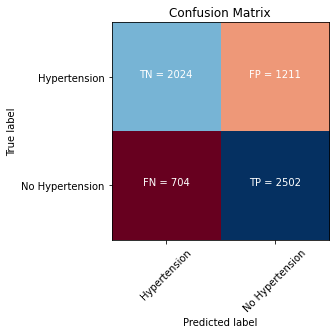

Average precision-recall score: 0.712


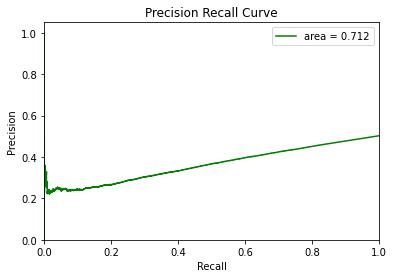

In [ ]:
#Make plots
plot_cm(svm, svm.predict(X_test).round())
plot_aucprc(svm, svm_score)

Classify data with XGBboost

In [ ]:
# XGB
base_learners = [
                 ('rf_4', XGBClassifier()),   
                ]

# Initialize Stacking Classifier with the Meta Learner
XGB = StackingClassifier(estimators=base_learners, 
                         #final_estimator = SVC(),
                         cv = 10)

# Extract score
#X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state=42)

XGB.fit(X_train, y_train).score(X_test, y_test)

y_train_predict = XGB.predict(X_train)
y_test_predict = XGB.predict(X_test)

#clf_score = clf.predict(X_test)#[:,1]
#clf_score = clf.score(X_test, y_test)
XGB_score = XGB.decision_function(X_test)
print(XGB_score)

[ 2.07236924  0.37036468 -2.40406559 ...  0.85608406  0.14084879
 -0.53950003]


XGB model evaluation

In [ ]:
XGB_train_auc, XGB_train_accuracy, XGB_train_recall, XGB_train_precision, XGB_train_specificity = print_report(y_train,y_train_predict, thresh)
print('Validation:')
XGB_valid_auc, XGB_valid_accuracy, XGB_valid_recall, XGB_valid_precision, XGB_valid_specificity = print_report(y_test,y_test_predict, thresh)
print(classification_report(y_test, y_test_predict.round(), target_names=target_names))
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test, y_test_predict)))
print('\nMean Score:',XGB.score(X_test, y_test))
#print("\nCross Validation Score: {:.2%}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=20))))

AUC:0.779
accuracy:0.779
recall:0.809
precision:0.763
specificity:0.748
sensitivity:1.338
prevalence:0.501
 
Validation:
AUC:0.764
accuracy:0.764
recall:0.798
precision:0.746
specificity:0.731
sensitivity:1.368
prevalence:0.498
 
                 precision    recall  f1-score   support

  Hypertension        0.78      0.73      0.76      3235
No Hypertension       0.75      0.80      0.77      3206

       accuracy                           0.76      6441
      macro avg       0.77      0.76      0.76      6441
   weighted avg       0.77      0.76      0.76      6441

Original ROC area: 0.764

Mean Score: 0.7643223102002794


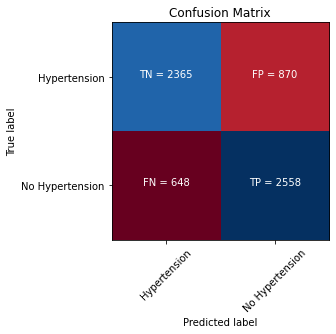

Average precision-recall score: 0.857


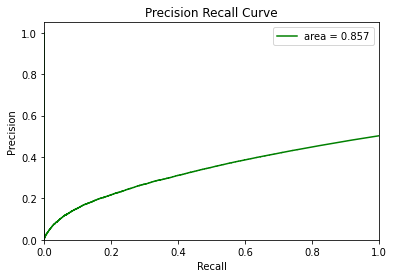

In [ ]:
#Make plots
plot_cm(XGB, XGB.predict(X_test).round())
plot_aucprc(XGB, XGB_score)

Classify data with LGBM model

In [ ]:
#LGBM
base_learners = [ 
                 ('rf_5', LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2, reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)),        
                ]

# Initialize Stacking Classifier with the Meta Learner
LGBM = StackingClassifier(estimators=base_learners, 
                         #final_estimator = SVC(),
                         cv = 10)

# Extract score
#X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state=42)

LGBM.fit(X_train, y_train).score(X_test, y_test)

y_train_predict = LGBM.predict(X_train)
y_test_predict = LGBM.predict(X_test)

#clf_score = clf.predict(X_test)#[:,1]
#clf_score = clf.score(X_test, y_test)
LGBM_score = LGBM.decision_function(X_test)
print(LGBM_score)

[ 3.57322141 -0.16794543 -2.65332613 ...  0.60985688  0.02473096
  3.36027205]


LGBM model evaluation

In [ ]:
LGBM_train_auc, LGBM_train_accuracy, LGBM_train_recall, LGBM_train_precision, LGBM_train_specificity = print_report(y_train,y_train_predict, thresh)
print('Validation:')
LGBM_valid_auc, LGBM_valid_accuracy, LGBM_valid_recall, LGBM_valid_precision, LGBM_valid_specificity = print_report(y_test,y_test_predict, thresh)
print(classification_report(y_test, y_test_predict.round(), target_names=target_names))
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test, y_test_predict)))
print('\nMean Score:',LGBM.score(X_test, y_test))
#print("\nCross Validation Score: {:.2%}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=20))))

AUC:0.867
accuracy:0.867
recall:0.831
precision:0.896
specificity:0.903
sensitivity:1.108
prevalence:0.501
 
Validation:
AUC:0.826
accuracy:0.826
recall:0.796
precision:0.845
specificity:0.856
sensitivity:1.169
prevalence:0.498
 
                 precision    recall  f1-score   support

  Hypertension        0.81      0.86      0.83      3235
No Hypertension       0.85      0.80      0.82      3206

       accuracy                           0.83      6441
      macro avg       0.83      0.83      0.83      6441
   weighted avg       0.83      0.83      0.83      6441

Original ROC area: 0.826

Mean Score: 0.8259587020648967


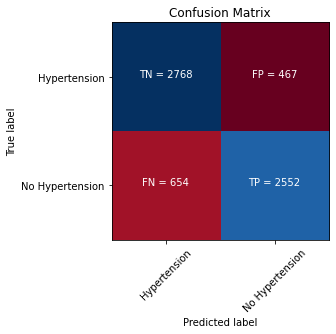

Average precision-recall score: 0.932


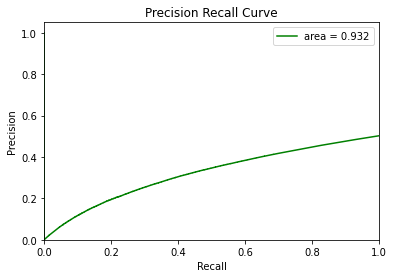

In [ ]:
#Make plots
plot_cm(LGBM, LGBM.predict(X_test).round())
plot_aucprc(LGBM, LGBM_score)

Classify data with KNN

In [ ]:
# KNN
base_learners = [
                 ('rf_2', KNeighborsClassifier(n_neighbors=5)),       
                ]

# Initialize Stacking Classifier with the Meta Learner
KNN = StackingClassifier(estimators=base_learners, 
                         #final_estimator = SVC(),
                         cv = 10)

# Extract score
#X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state=42)

KNN.fit(X_train, y_train).score(X_test, y_test)

y_train_predict = KNN.predict(X_train)
y_test_predict = KNN.predict(X_test)

#clf_score = clf.predict(X_test)#[:,1]
#clf_score = clf.score(X_test, y_test)
KNN_score = KNN.decision_function(X_test)
print(KNN_score)

[ 1.69529346  0.80033534 -1.88453899 ...  0.80033534  1.69529346
  0.80033534]


KNN model evaluation

In [ ]:
KNN_train_auc, KNN_train_accuracy, KNN_train_recall, KNN_train_precision, KNN_train_specificity = print_report(y_train,y_train_predict, thresh)
print('Validation:')
KNN_valid_auc, KNN_valid_accuracy, KNN_valid_recall, KNN_valid_precision, KNN_valid_specificity = print_report(y_test,y_test_predict, thresh)
print(classification_report(y_test, y_test_predict.round(), target_names=target_names))
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test, y_test_predict)))
print('\nMean Score:',KNN.score(X_test, y_test))
#print("\nCross Validation Score: {:.2%}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=20))))

AUC:0.865
accuracy:0.865
recall:0.848
precision:0.879
specificity:0.883
sensitivity:1.132
prevalence:0.501
 
Validation:
AUC:0.764
accuracy:0.764
recall:0.762
precision:0.763
specificity:0.765
sensitivity:1.307
prevalence:0.498
 
                 precision    recall  f1-score   support

  Hypertension        0.76      0.77      0.76      3235
No Hypertension       0.76      0.76      0.76      3206

       accuracy                           0.76      6441
      macro avg       0.76      0.76      0.76      6441
   weighted avg       0.76      0.76      0.76      6441

Original ROC area: 0.764

Mean Score: 0.7635460332246545


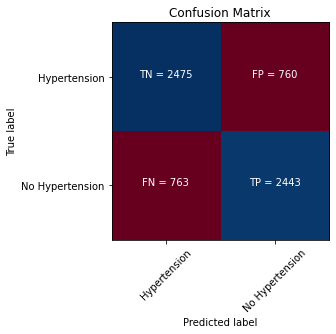

Average precision-recall score: 0.778


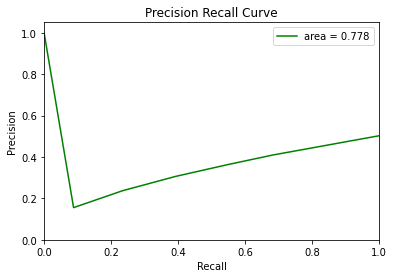

In [ ]:
#Make plots
plot_cm(KNN, KNN.predict(X_test).round())
plot_aucprc(KNN, KNN_score)

Classify data with RandomForest model

In [ ]:
# RF
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators=10, random_state=42)),         
                ]
# Initialize Stacking Classifier with the Meta Learner
RF = StackingClassifier(estimators=base_learners, 
                         #final_estimator = SVC(),
                         cv = 10)

# Extract score
#X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state=42)

RF.fit(X_train, y_train).score(X_test, y_test)

y_train_predict = RF.predict(X_train)
y_test_predict = RF.predict(X_test)

#clf_score = clf.predict(X_test)#[:,1]
#clf_score = clf.score(X_test, y_test)
RF_score = RF.decision_function(X_test)
print(RF_score)

[ 1.72935493  1.72935493 -2.51265491 ... -0.08864928  2.33535634
 -0.08864928]


RandomForest model evaluation

In [ ]:
RF_train_auc, RF_train_accuracy, RF_train_recall, RF_train_precision, RF_train_specificity = print_report(y_train,y_train_predict, thresh)
print('Validation:')
RF_valid_auc, RF_valid_accuracy, RF_valid_recall, RF_valid_precision, RF_valid_specificity = print_report(y_test,y_test_predict, thresh)
print(classification_report(y_test, y_test_predict.round(), target_names=target_names))
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test, y_test_predict)))
print('\nMean Score:',RF.score(X_test, y_test))
#print("\nCross Validation Score: {:.2%}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=20))))

AUC:0.992
accuracy:0.992
recall:0.988
precision:0.997
specificity:0.997
sensitivity:1.003
prevalence:0.501
 
Validation:
AUC:0.785
accuracy:0.786
recall:0.763
precision:0.797
specificity:0.808
sensitivity:1.238
prevalence:0.498
 
                 precision    recall  f1-score   support

  Hypertension        0.77      0.81      0.79      3235
No Hypertension       0.80      0.76      0.78      3206

       accuracy                           0.79      6441
      macro avg       0.79      0.79      0.79      6441
   weighted avg       0.79      0.79      0.79      6441

Original ROC area: 0.785

Mean Score: 0.7855922993324018


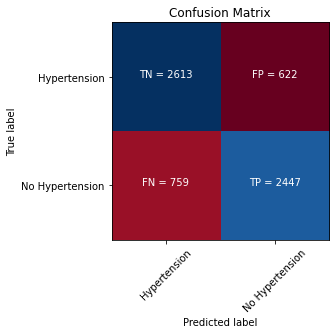

Average precision-recall score: 0.839


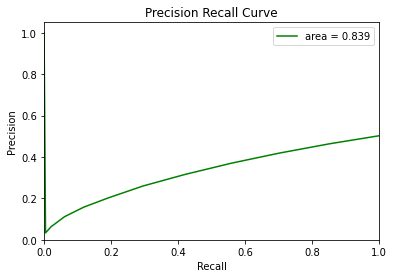

In [ ]:
#Make plots
plot_cm(RF, RF.predict(X_test).round())
plot_aucprc(RF, RF_score)

Classify data with RF & KNN model combined

In [ ]:
# RF-KNN-SVM
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('KNN', KNeighborsClassifier(n_neighbors=5)),        
                ]

# Initialize Stacking Classifier with the Meta Learner
RKS= StackingClassifier(estimators=base_learners, 
                         final_estimator = SVC(),
                         cv = 10)

# Extract score
#X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state=42)

RKS.fit(X_train, y_train).score(X_test, y_test)

y_train_predict = RKS.predict(X_train)
y_test_predict = RKS.predict(X_test)

#clf_score = clf.predict(X_test)#[:,1]
#clf_score = clf.score(X_test, y_test)
RKS_score = RKS.decision_function(X_test)
print(RKS_score)

[ 0.99997845  1.04979025 -1.06410595 ...  0.60709354  1.10561918
  0.60709354]


Evaluation of RF & KNN combined model

In [ ]:
RKS_train_auc, RKS_train_accuracy, RKS_train_recall, RKS_train_precision, RKS_train_specificity = print_report(y_train,y_train_predict, thresh)
print('Validation:')
RKS_valid_auc, RKS_valid_accuracy, RKS_valid_recall, RKS_valid_precision, RKS_valid_specificity = print_report(y_test,y_test_predict, thresh)
print(classification_report(y_test, y_test_predict.round(), target_names=target_names))
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test, y_test_predict)))
print('\nMean Score:',RKS.score(X_test, y_test))
#print("\nCross Validation Score: {:.2%}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=20))))

AUC:0.990
accuracy:0.990
recall:0.985
precision:0.994
specificity:0.994
sensitivity:1.006
prevalence:0.501
 
Validation:
AUC:0.803
accuracy:0.803
recall:0.825
precision:0.789
specificity:0.782
sensitivity:1.279
prevalence:0.498
 
                 precision    recall  f1-score   support

  Hypertension        0.82      0.78      0.80      3235
No Hypertension       0.79      0.82      0.81      3206

       accuracy                           0.80      6441
      macro avg       0.80      0.80      0.80      6441
   weighted avg       0.80      0.80      0.80      6441

Original ROC area: 0.803

Mean Score: 0.8032914143766496


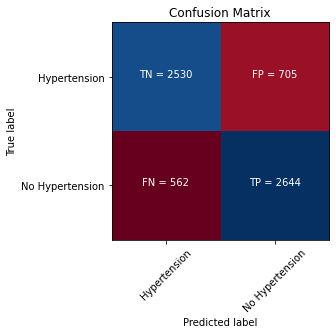

Average precision-recall score: 0.842


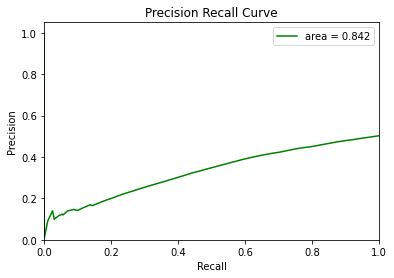

In [ ]:
#Make plots
plot_cm(RKS, RKS.predict(X_test).round())
plot_aucprc(RKS, RKS_score)

Classify data with RFF,KNN & XGB combined model

In [ ]:
# RKXS
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('KNN', KNeighborsClassifier(n_neighbors=5)),
                 ('XGB', XGBClassifier()),         
                ]

# Initialize Stacking Classifier with the Meta Learner
RKXS = StackingClassifier(estimators=base_learners, 
                         final_estimator = SVC(),
                         cv = 10)

# Extract score
#X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state=42)

RKXS.fit(X_train, y_train).score(X_test, y_test)

y_train_predict = RKXS.predict(X_train)
y_test_predict = RKXS.predict(X_test)

#clf_score = clf.predict(X_test)#[:,1]
#clf_score = clf.score(X_test, y_test)
RKXS_score = RKXS.decision_function(X_test)
print(RKXS_score)

[ 1.01930109  1.10958788 -1.04901685 ...  0.51308553  1.0046449
 -0.00590114]


Evaluation of RF,KNN & XGB combined model

In [ ]:
RKXS_train_auc, RKXS_train_accuracy, RKXS_train_recall, RKXS_train_precision, RKXS_train_specificity = print_report(y_train,y_train_predict, thresh)
print('Validation:')
RKXS_valid_auc, RKXS_valid_accuracy, RKXS_valid_recall, RKXS_valid_precision, RKXS_valid_specificity = print_report(y_test,y_test_predict, thresh)
print(classification_report(y_test, y_test_predict.round(), target_names=target_names))
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test, y_test_predict)))
print('\nMean Score:',RKXS.score(X_test, y_test))
#print("\nCross Validation Score: {:.2%}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=20))))

AUC:0.964
accuracy:0.964
recall:0.979
precision:0.950
specificity:0.948
sensitivity:1.055
prevalence:0.501
 
Validation:
AUC:0.808
accuracy:0.808
recall:0.830
precision:0.794
specificity:0.786
sensitivity:1.272
prevalence:0.498
 
                 precision    recall  f1-score   support

  Hypertension        0.82      0.79      0.80      3235
No Hypertension       0.79      0.83      0.81      3206

       accuracy                           0.81      6441
      macro avg       0.81      0.81      0.81      6441
   weighted avg       0.81      0.81      0.81      6441

Original ROC area: 0.808

Mean Score: 0.808104331625524


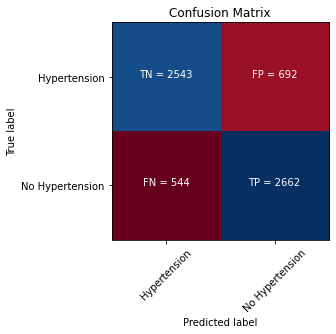

Average precision-recall score: 0.868


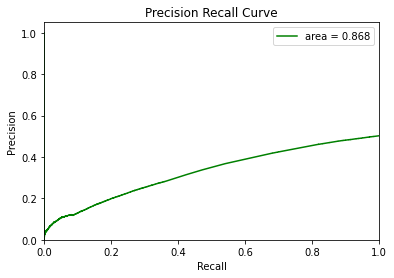

In [ ]:
#Make plots
plot_cm(RKXS, RKXS.predict(X_test).round())
plot_aucprc(RKXS, RKXS_score)

Classify data with RF , KNN & LGBM combined model

In [ ]:
# RKLS = Main CLassifier
base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('rf_2', KNeighborsClassifier(n_neighbors=5)),
                 #('rf_3', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)),
                 #('rf_4', XGBClassifier()),  
                 ('rf_5', LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2, reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)),
                 #('rf_6', SVC()),
                 #('rf_7', LogisticRegression(random_state = 42)),
                 #('rf_8', ElasticNetCV(random_state=0)),
                 #('rf_9', SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)),
                 #('rf_10', GaussianNB()),
                 #('rf_11', DecisionTreeClassifier(max_depth = 10, random_state = 42)),
                 #('rf_12', NuSVC()),
                 #('rf_13', ),         
                ]
#layer_two_estimators = [
#                        ('dt_2', KNeighborsClassifier(n_neighbors=5)),
#                       ('rf_2', RandomForestClassifier(n_estimators=50, random_state=42)),
#                        ('rf_3', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42))
#                      ]
#layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=NuSVC())

# Create Final model by 
#clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)

# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators=base_learners, 
                         final_estimator = SVC(),
                         cv = 10)

# Extract score
#X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state=42)

clf.fit(X_train, y_train).score(X_test, y_test)

y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

#clf_score = clf.predict(X_test)#[:,1]
#clf_score = clf.score(X_test, y_test)
clf_score = clf.decision_function(X_test)
print(clf_score)

[ 1.26242923  0.43354531 -1.00075635 ... -0.48378863  1.18417573
  2.81325722]


EValuate RF,KNN & LGBM combined model

In [ ]:
clf_train_auc, clf_train_accuracy, clf_train_recall, clf_train_precision, clf_train_specificity = print_report(y_train,y_train_predict, thresh)
print('Validation:')
clf_valid_auc, clf_valid_accuracy, clf_valid_recall, clf_valid_precision, clf_valid_specificity = print_report(y_test,y_test_predict, thresh)
print(classification_report(y_test, y_test_predict.round(), target_names=target_names))
print("Original ROC area: {:0.3f}".format(roc_auc_score(y_test, y_test_predict)))
print('\nMean Score:',clf.score(X_test, y_test))
#print("\nCross Validation Score: {:.2%}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=20))))

AUC:0.951
accuracy:0.951
recall:0.919
precision:0.982
specificity:0.984
sensitivity:1.017
prevalence:0.501
 
Validation:
AUC:0.851
accuracy:0.851
recall:0.789
precision:0.898
specificity:0.912
sensitivity:1.097
prevalence:0.498
 
                 precision    recall  f1-score   support

  Hypertension        0.81      0.91      0.86      3235
No Hypertension       0.90      0.79      0.84      3206

       accuracy                           0.85      6441
      macro avg       0.86      0.85      0.85      6441
   weighted avg       0.86      0.85      0.85      6441

Original ROC area: 0.851

Mean Score: 0.8507995652848936


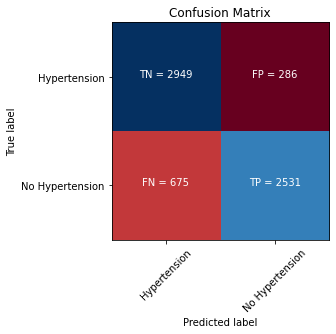

Average precision-recall score: 0.933


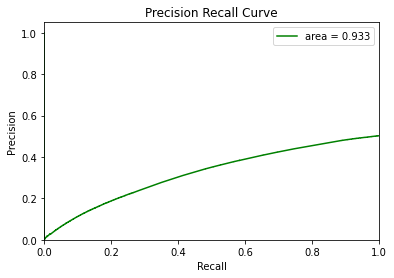

In [ ]:
#Make plots
plot_cm(clf, clf.predict(X_test).round())
plot_aucprc(clf, clf_score)

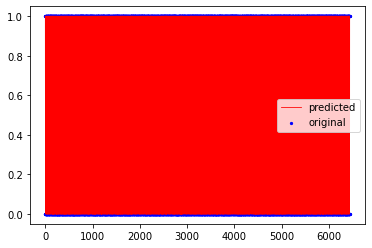

In [ ]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_test_predict, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [ ]:
print('Train:')
print('AUC Score:' ,roc_auc_score(y_train, y_train_predict))
print('Accuracy:' ,accuracy_score(y_train, y_train_predict))
print('Recall Score:' ,recall_score(y_train, y_train_predict))
print('Precision Score:' ,precision_score(y_train, y_train_predict))

print('\nTest:')
print('AUC Score:' ,roc_auc_score(y_test, y_test_predict))
print('Accuracy:' ,accuracy_score(y_test, y_test_predict))
print('Recall Score:' ,recall_score(y_test, y_test_predict))
print('Precision Score:' ,precision_score(y_test, y_test_predict))


Train:
AUC Score: 0.9512842039603109
Accuracy: 0.9512479136746497
Recall Score: 0.919044665012407
Precision Score: 0.9824270557029178

Test:
AUC Score: 0.8505246152644627
Accuracy: 0.8507995652848936
Recall Score: 0.7894572676232064
Precision Score: 0.8984735534256301


Evaluate & find the best model for classification

             Model       AUC  Accuracy    Recall  Precision  Specificity
0              SVM  0.703034  0.702686  0.780412   0.673849     0.625657
1              XGB  0.764473  0.764322  0.797879   0.746208     0.731066
2              KNN  0.763539  0.763546  0.762009   0.762722     0.765070
3             LGBM  0.825824  0.825959  0.796007   0.845313     0.855641
4               RF  0.785492  0.785592  0.763256   0.797328     0.807728
5         RF + KNN  0.803387  0.803291  0.824704   0.789489     0.782071
6   RF + KNN + XGB  0.808204  0.808104  0.830318   0.793679     0.786090
7  RF + KNN + LGBM  0.850525  0.850800  0.789457   0.898474     0.911592


<Figure size 432x288 with 0 Axes>

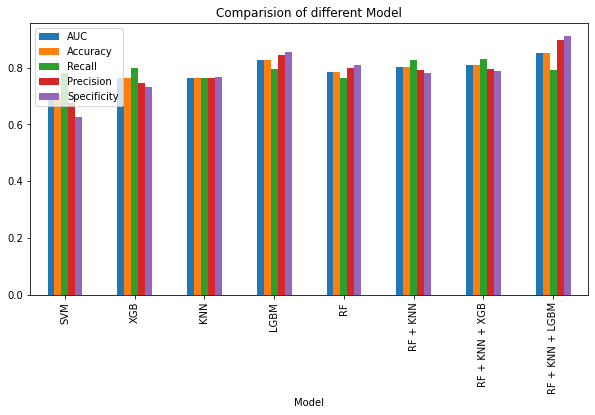

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
  
# create dataframe
df = pd.DataFrame([['SVM', svm_valid_auc, svm_valid_accuracy, svm_valid_recall, svm_valid_precision, svm_valid_specificity], 
                   ['XGB', XGB_valid_auc, XGB_valid_accuracy, XGB_valid_recall, XGB_valid_precision, XGB_valid_specificity], 
                   ['KNN', KNN_valid_auc, KNN_valid_accuracy, KNN_valid_recall, KNN_valid_precision, KNN_valid_specificity],
                   ['LGBM', LGBM_valid_auc, LGBM_valid_accuracy, LGBM_valid_recall, LGBM_valid_precision, LGBM_valid_specificity],
                   ['RF', RF_valid_auc, RF_valid_accuracy, RF_valid_recall, RF_valid_precision, RF_valid_specificity],
                   ['RF + KNN', RKS_valid_auc, RKS_valid_accuracy, RKS_valid_recall, RKS_valid_precision, RKS_valid_specificity],
                   ['RF + KNN + XGB', RKXS_valid_auc, RKXS_valid_accuracy, RKXS_valid_recall, RKXS_valid_precision, RKXS_valid_specificity],
                   ['RF + KNN + LGBM', clf_valid_auc, clf_valid_accuracy, clf_valid_recall, clf_valid_precision, clf_valid_specificity]],
                  columns=['Model', 'AUC', 'Accuracy', 'Recall', 'Precision', 'Specificity'])
# view data
print(df)

fig_2 = plt.figure()
# plot grouped bar chart
df.plot(x='Model',
        kind='bar',
        stacked=False,
        #subplots=True,
        figsize=(10, 5),
        title='Comparision of different Model')
fig_2.savefig('Comp-10.png')

  Feature set       SVM  ...  RF+KNN+XGB  Proposed Model (RF+KNN+LGBM)
0       set 1  0.702686  ...    0.808104                      0.850800
1       set 2  0.689023  ...    0.819438                      0.853905
2       set 3  0.689023  ...    0.817730                      0.854836

[3 rows x 9 columns]


<Figure size 432x288 with 0 Axes>

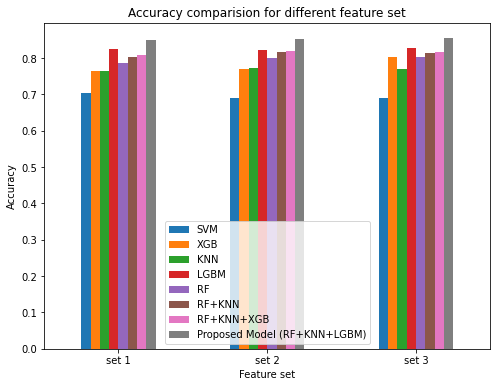

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
  
# create dataframe
# Accuracy
df = pd.DataFrame([
                   ['set 1', 0.702686, 0.764322, 0.763546, 0.825959, 0.785592, 0.803291, 0.808104, 0.850800], 
                   ['set 2', 0.689023, 0.769601, 0.773638, 0.822854, 0.801273, 0.815712, 0.819438, 0.853905], 
                   ['set 3', 0.689023, 0.802670, 0.769601, 0.828443, 0.802670, 0.814780, 0.817730, 0.854836],
                   ],
                  columns=['Feature set', 'SVM', 'XGB', 'KNN', 'LGBM', 'RF', 'RF+KNN', 'RF+KNN+XGB', 'Proposed Model (RF+KNN+LGBM)' ])
# view data
print(df)

fig_3 = plt.figure()
# plot grouped bar chart
df.plot(x='Feature set',
        kind='bar',
        stacked=False,
        style= 'list',
        #legend= 'true', 
        #subplots=True,
        figsize=(8, 6),
        rot='horizontal',
        ylabel='Accuracy',
        title='Accuracy comparision for different feature set')
fig_3.savefig('Accuracy.png')

  Feature set       SVM  ...  RF+KNN+XGB  Proposed Model (RF+KNN+LGBM)
0       set 1  0.703034  ...    0.808204                      0.850525
1       set 2  0.689279  ...    0.819526                      0.853693
2       set 3  0.689274  ...    0.817827                      0.854655

[3 rows x 9 columns]


<Figure size 432x288 with 0 Axes>

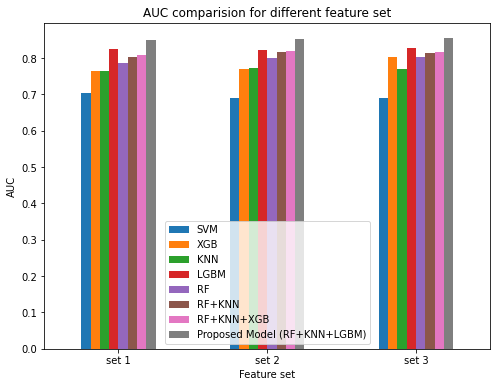

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
  
# create dataframe
# AUC
df = pd.DataFrame([
                   ['set 1', 0.703034, 0.764473, 0.763539, 0.825824, 0.785492, 0.803387, 0.808204, 0.850525], 
                   ['set 2', 0.689279, 0.769760, 0.773637, 0.822735, 0.801206, 0.815842, 0.819526, 0.853693], 
                   ['set 3', 0.689274, 0.802606, 0.769545, 0.828331, 0.802606, 0.814899, 0.817827, 0.854655],
                   ],
                  columns=['Feature set', 'SVM', 'XGB', 'KNN', 'LGBM', 'RF', 'RF+KNN', 'RF+KNN+XGB', 'Proposed Model (RF+KNN+LGBM)' ])
# view data
print(df)

fig_4 = plt.figure()
# plot grouped bar chart
df.plot(x='Feature set',
        kind='bar',
        stacked=False,
        style= 'list',
        #legend= 'true', 
        #subplots=True,
        figsize=(8, 6),
        rot='horizontal',
        ylabel='AUC',
        title='AUC comparision for different feature set')
fig_4.savefig('AUC.png')

In [ ]:
##Computing false and true positive rates
fpr_svm, tpr_svm, thresholds = roc_curve(y_test, svm_score)
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, RF_score)
fpr_XGB, tpr_XGB, thresholds = roc_curve(y_test, XGB_score)
fpr_LGBM, tpr_LGBM, thresholds = roc_curve(y_test, LGBM_score)
fpr_KNN, tpr_KNN, thresholds = roc_curve(y_test, KNN_score)
fpr_RKS, tpr_RKS, thresholds = roc_curve(y_test, RKS_score)
fpr_RKXS, tpr_RKXS, thresholds = roc_curve(y_test, RKXS_score)
fpr_clf, tpr_clf, thresholds = roc_curve(y_test, clf_score)
#print(fpr_clf)
#print(tpr_clf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


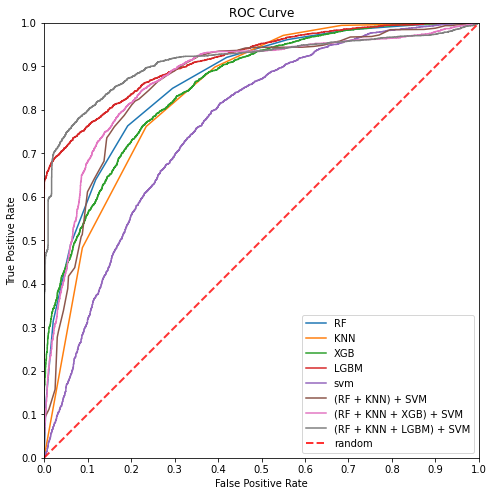

In [ ]:
fig_1 = plt.figure(figsize=(8,8))
plt.plot(fpr_RF, tpr_RF, label='RF') #Ensamble
plt.plot(fpr_KNN, tpr_KNN, label='KNN') #Ensamble
plt.plot(fpr_XGB, tpr_XGB, label='XGB') #Ensamble
plt.plot(fpr_LGBM, tpr_LGBM, label='LGBM') #Ensamble
plt.plot(fpr_svm, tpr_svm, label='svm') #Ensamble
plt.plot(fpr_RKS, tpr_RKS, label='(RF + KNN) + SVM') #Ensamble
plt.plot(fpr_RKXS, tpr_RKXS, label='(RF + KNN + XGB) + SVM') #Ensamble
plt.plot(fpr_clf, tpr_clf, label='(RF + KNN + LGBM) + SVM') #Ensamble

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random', alpha=.8)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()
plt.axes().set_aspect('equal')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(b=None)
plt.show()
fig_1.savefig('ROC_10f.png')